##**Loading Libraries**

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
import time
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import mean_squared_error, confusion_matrix
import xgboost as xgb
from xgboost import XGBRegressor
import statsmodels.api as sm

####PIPELINE#####
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.externals import joblib
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin,ClassifierMixin

##**Loading Dataset**

*From previous notebook*

The data description is provided as follows - 


*   Trip Duration (seconds)
*   Start Time and Date
*   Stop Time and Date
*   Start Station Name
*   End Station Name
*   Station ID
*   Station Lat/Long
*   Bike ID - Converted to String Data Type
*   User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
*   Gender (Zero=unknown; 1=male; 2=female)
*   Year of Birth
*   Count - No. of Times a Trip Occurs in the dataset (Start Station - End Station)
*   Distance Travelled (Meters)
*   Median Speed (m/s)
*   Age - Float vlaue in Years

**Problem Statement:** *We need to be able to predict the duration of the trip given Start & End Destinations*

In [2]:
df_model1 = pd.read_csv('Preprocessed_CitiBike_2017.csv')
df_model1.head()

,Unnamed: 0,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Count,Distance Travelled (Meters),Median Speed (m/s),Age
0,0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226.0,W 82 St & Central Park West,40.782750,-73.971370,3165.0,Central Park West & W 72 St,40.775794,-73.976206,25542.0,Subscriber,1965.0,2.0,3,874.394902,1.285875,55.0
1,1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,498.0,Broadway & W 32 St,40.748549,-73.988084,21136.0,Subscriber,1987.0,2.0,2,2160.858819,1.685537,33.0
2,6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499.0,Broadway & W 60 St,40.769155,-73.981918,479.0,9 Ave & W 45 St,40.760193,-73.991255,27294.0,Subscriber,1973.0,1.0,26,1269.844833,2.271637,47.0
3,7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,362.0,Broadway & W 37 St,40.751726,-73.987535,445.0,E 10 St & Avenue A,40.727408,-73.981420,23288.0,Subscriber,1977.0,2.0,2,2753.588103,3.333642,43.0
4,8,255,2017-01-01 00:05:47,2017-01-01 00:10:02,430.0,York St & Jay St,40.701485,-73.986569,242.0,Carlton Ave & Flushing Ave,40.697787,-73.973736,25041.0,Subscriber,1989.0,1.0,81,1157.737648,4.540148,31.0


In [3]:
df_model1.shape

(412211, 20)

##**Helper Functions**

In [4]:
# Functions that we will use later on
def data_info(data):
    return data.info()

def creating_boxplots(size, target, features, data):
    plt.figure(figsize=size)
    for i in range(len(numerical_vars)):
        plt.subplot(5, 3, i+1)
        sns.boxplot(x=target, y=features[i], data=data )
        
def creating_distplot(size, data, features):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.distplot(data[features[i]])
        
def crossCorrelation(data):
    corr = data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, 
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)
    print(corr)

def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 10
    height = 8
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName,
                       ax=ax1)

    plt.title(Title)
    plt.xlabel('Trip Duration')
    plt.ylabel('Mean Values')
    plt.show()
    plt.close()

#Defining Box-plotting function
def plot_var(df, var):
  plt.figure(figsize = (14, 6))
  plt.subplot(1, 2, 1)
  
  #if the independent variable is an integer
  if df[var].dtype == 'int64':
    df[var].value_counts().sort_index().plot()
    plt.xticks(rotation = 45)
    plt.xlabel(var)
    plt.ylabel('Counts')
    plt.title('Distribution of {}'.format(var))
    plt.subplot(1, 2, 2)
    
  else:
    #We change variable data type to Categorical and group them by the mean of 
    #Trip Duration in every column
    mean = df.groupby(var)['Trip Duration'].mean()
    df[var] = df[var].astype('category').copy()
    levels = mean.sort_values().index.tolist()
    df[var].cat.reorder_categories(levels, inplace=True)
    df[var].value_counts().plot()
    plt.xticks(rotation = 45)
    plt.xlabel(var)
    plt.ylabel('Counts')
    plt.title('Distribution of {}'.format(var))
    plt.subplot(1, 2, 2)

    if df[var].dtype == 'int64' or var == 'User ID':
        #plot the mean salary for each category and fill between the 
        #(mean - std, mean + std)
        mean = df.groupby(var)['Trip Duration'].mean()
        std = df.groupby(var)['Trip Duration'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
        
    else:
        sns.boxplot(x=var, y='Trip Duration',
                    data = df.sort_values('Trip Duration'))
    
    plt.xticks(rotation = 45)
    plt.ylabel('Trip Duration')
    plt.title('Relationship of Trip Duration with {}'.format(var))
    plt.show()

def RushHour(time):
  if ((time).hour >= 0 and (time).hour < 7):
    return 'Not Rush Hour'
  elif ((time).hour >= 7 and (time).hour < 13):
    return 'During Rush Hour'
  elif ((time).hour >= 13 and (time).hour < 14):
    return 'During Rush Hour'
  elif ((time).hour >= 14 and (time).hour < 17):
    return 'Not Rush Hour'
  elif ((time).hour >=17 and (time).hour < 19):
    return 'During Rush Hour'
  else:
    return 'Not Rush Hour'

#Using Pandas series to sort out time of year and day of week.
def get_date_info(df):
  df['d_week'] = df['Start Time'].dt.dayofweek
  #df['m_of_year'] = df['Start Time'].dt.month
  df['Time_of_Day'] = df['Start Time'].dt.hour

  #Weekend or not? 1.0 = Weekday, 0.0 = Weekend
  df['d_week'] = (df['d_week']<5).astype(int)

  # Winter(0), Spring(1), Summer(2) and Fall(9)
  #df['m_of_year'] = df['m_of_year'].replace(to_replace=[12,1,2], value = 0)
  #df['m_of_year'] = df['m_of_year'].replace(to_replace=[3,4], value = 1)
  #df['m_of_year'] = df['m_of_year'].replace(to_replace=[5,6,7,8], value = 2)
  #df['m_of_year'] = df['m_of_year'].replace(to_replace=[9,10,11], value = 3)

  # Night (20:00 - 5:00), Morning (5:00 - 12:00), Afternoon (12:00 - 15:00),
  # Evening (15:00 - 20:00)
  df['Time_of_Day'] = pd.cut(df['Time_of_Day'], bins = [-1, 5, 12, 15, 20, 23],
                             labels = ['Night', 'Morning', 'Afternoon',
                                       'Evening', 'Late Night'])
  
  df['Time_of_Day'] = df['Time_of_Day'].replace(to_replace = 'Late Night',
                                                value = 'Night')
  df['Time_of_Day'] = df['Time_of_Day'].cat.remove_unused_categories()
    
  #df['m_of_year'] = df['m_of_year'].astype('category')
  df['d_week'] = df['d_week'].astype('category')

  return(df)

# Function to Find average speed as a function of Rider User Type and Trip route
def get_speed_distance(df):

  df['Start Station Name'] = df['Start Station Name'].astype(str)
  df['End Station Name'] = df['End Station Name'].astype(str)
  df['Trip'] = df['Start Station Name'] + ' TO ' + df['End Station Name']
  df['Trip'] = df['Trip'].astype('category')
  
  df['route_avg_speed'] = df.groupby(['Trip','User Type'])['Median Speed (m/s)'].transform(lambda x: x.mean())
  df['route_avg_duration'] = df.groupby(['Trip','User Type'])['Trip Duration'].transform(lambda x: x.median())
  
  return df

def drop_data(df):
  df = df.drop(['Stop Time','Start Station ID','Start Station Latitude',
                'Start Station Longitude','Start Coordinates','End Station ID',
                'End Station Latitude', 'End Station Longitude','Start Time',
                'End Coordinates','Bike ID','Start Station Name','Birth Year',
                'End Station Name'], axis = 1)
  return df

##**EDA for Modelling**

In [5]:
df_model1.columns

Index(['Unnamed: 0', 'Trip Duration', 'Start Time', 'Stop Time',
       'Start Station ID', 'Start Station Name', 'Start Station Latitude',
       'Start Station Longitude', 'End Station ID', 'End Station Name',
       'End Station Latitude', 'End Station Longitude', 'Bike ID', 'User Type',
       'Birth Year', 'Gender', 'Count', 'Distance Travelled (Meters)',
       'Median Speed (m/s)', 'Age'],
      dtype='object')

In [6]:
#These columns are not needed for modelling
#Birth year is not needed as we have a column Age
#Also, once distance is calculated, lats and longs won't be needed either
df_model1.drop(['Unnamed: 0','Birth Year','Start Station Latitude',
                'Start Station Longitude','End Station Latitude',
                'End Station Longitude','Start Station ID',
                'End Station ID','Count'], axis = 1, inplace=True)
df_model1.head()

,Trip Duration,Start Time,Stop Time,Start Station Name,End Station Name,Bike ID,User Type,Gender,Distance Travelled (Meters),Median Speed (m/s),Age
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,25542.0,Subscriber,2.0,874.394902,1.285875,55.0
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,21136.0,Subscriber,2.0,2160.858819,1.685537,33.0
2,559,2017-01-01 00:05:00,2017-01-01 00:14:20,Broadway & W 60 St,9 Ave & W 45 St,27294.0,Subscriber,1.0,1269.844833,2.271637,47.0
3,826,2017-01-01 00:05:37,2017-01-01 00:19:24,Broadway & W 37 St,E 10 St & Avenue A,23288.0,Subscriber,2.0,2753.588103,3.333642,43.0
4,255,2017-01-01 00:05:47,2017-01-01 00:10:02,York St & Jay St,Carlton Ave & Flushing Ave,25041.0,Subscriber,1.0,1157.737648,4.540148,31.0


In [7]:
print("Dataset Shape:", df_model1.shape)
df_model1.isnull().sum()

Dataset Shape: (412211, 11)


Trip Duration                  0
Start Time                     0
Stop Time                      0
Start Station Name             0
End Station Name               0
Bike ID                        0
User Type                      0
Gender                         0
Distance Travelled (Meters)    0
Median Speed (m/s)             0
Age                            0
dtype: int64

In [8]:
#Converting Bike ID from Num to String data type
#Ensuring that date is formatted correctly

df_model1['Bike ID'] = df_model1['Bike ID'].astype(str)
df_model1['Age'] = df_model1['Age'].astype(int)

df_model1['Start Time'] = pd.to_datetime(df_model1['Start Time'])
df_model1['Stop Time'] = pd.to_datetime(df_model1['Stop Time'])
df_model1['Start Station Name'] = df_model1['Start Station Name'].astype('category')
df_model1['End Station Name'] = df_model1['End Station Name'].astype('category')
df_model1['User Type'] = df_model1['User Type'].astype('category')
df_model1['Gender'] = df_model1['Gender'].astype('category')
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412211 entries, 0 to 412210
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Trip Duration                412211 non-null  int64         
 1   Start Time                   412211 non-null  datetime64[ns]
 2   Stop Time                    412211 non-null  datetime64[ns]
 3   Start Station Name           412211 non-null  category      
 4   End Station Name             412211 non-null  category      
 5   Bike ID                      412211 non-null  object        
 6   User Type                    412211 non-null  category      
 7   Gender                       412211 non-null  category      
 8   Distance Travelled (Meters)  412211 non-null  float64       
 9   Median Speed (m/s)           412211 non-null  float64       
 10  Age                          412211 non-null  int64         
dtypes: category(4), datetime64

In [9]:
print("Number of Duplicate Records:", df_model1.duplicated().sum())

Number of Duplicate Records: 0


Therefore, there are no duplicate rows that will need to be removed. Nor do we have any null values

In [10]:
df_model1.describe()  

,Trip Duration,Distance Travelled (Meters),Median Speed (m/s),Age
count,412211.000000,412211.000000,412211.000000,412211.000000
mean,647.650339,1683.976025,2.716587,42.002402
std,481.382506,1258.398790,0.741226,10.639746
min,61.000000,36.747344,0.006521,20.000000
25%,326.000000,844.464957,2.262028,33.000000
50%,511.000000,1328.400161,2.706639,40.000000
75%,818.000000,2101.703554,3.178981,50.000000
max,9939.000000,14458.685244,7.810612,65.000000


We can see that the mean and the median (50%) for most columns of statistical significance to our model are very similar. This suggests that we would not need to transform our data, at least based on their distribution. However, **we will investigate this assumption later by plotting our data**.

###**Descriptive Features**

In [11]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412211 entries, 0 to 412210
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Trip Duration                412211 non-null  int64         
 1   Start Time                   412211 non-null  datetime64[ns]
 2   Stop Time                    412211 non-null  datetime64[ns]
 3   Start Station Name           412211 non-null  category      
 4   End Station Name             412211 non-null  category      
 5   Bike ID                      412211 non-null  object        
 6   User Type                    412211 non-null  category      
 7   Gender                       412211 non-null  category      
 8   Distance Travelled (Meters)  412211 non-null  float64       
 9   Median Speed (m/s)           412211 non-null  float64       
 10  Age                          412211 non-null  int64         
dtypes: category(4), datetime64

In [12]:
numerical_vars = df_model1[['Trip Duration','Distance Travelled (Meters)',
                  'Median Speed (m/s)','Age']]

target = df_model1['Trip Duration']

**Distribution Plots**

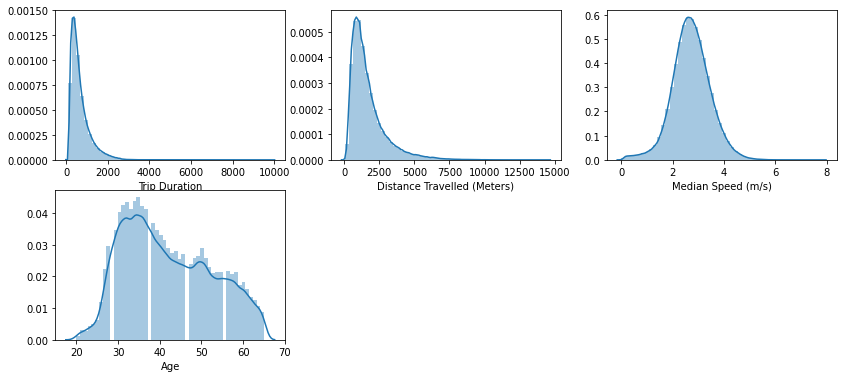

In [13]:
#for numerical features only
num_vars = df_model1.select_dtypes(exclude=['object','category',
                                            'datetime64']).columns

# Creating distribution plots
creating_distplot((14,16), df_model1, num_vars)

We see that the Distribution plots for 'Trip Duration' and 'Distance Travelled' seem a little right skewed, while 'Median Speed (m/s)' seems to have a fairly random distribution. These could potentially add some bias to the model later on. We can learn more about their importance as features later.

###**Cross Correlations**

In [14]:
#df_model1.drop(['Start Station Name', 'End Station Name', 'Bike ID'],
                           #axis = 1, inplace = True)

In [15]:
#Dummify categorical data and avoid dummy variable trap
#df_model1 = pd.get_dummies(df_model1, drop_first = True)
#df_model1.dtypes

In [16]:
df_model1.corr().loc[:,'Trip Duration']

Trip Duration                  1.000000
Distance Travelled (Meters)    0.803347
Median Speed (m/s)            -0.211379
Age                            0.056628
Name: Trip Duration, dtype: float64

                             Trip Duration  ...       Age
Trip Duration                     1.000000  ...  0.056628
Distance Travelled (Meters)       0.803347  ...  0.021747
Median Speed (m/s)               -0.211379  ... -0.105267
Age                               0.056628  ...  1.000000

[4 rows x 4 columns]


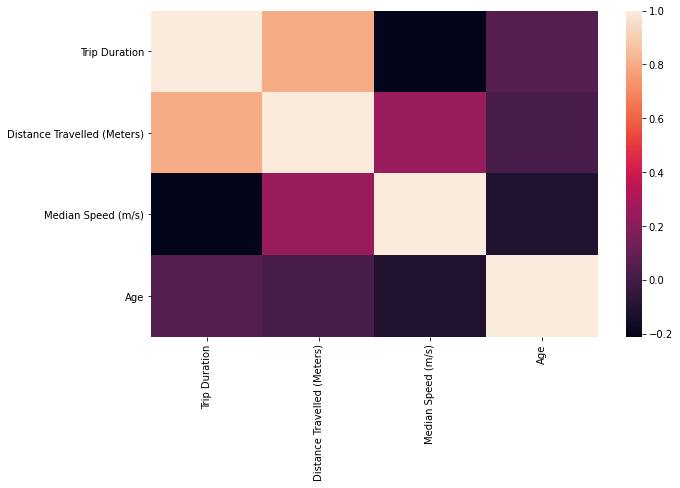

In [17]:
crossCorrelation(df_model1)

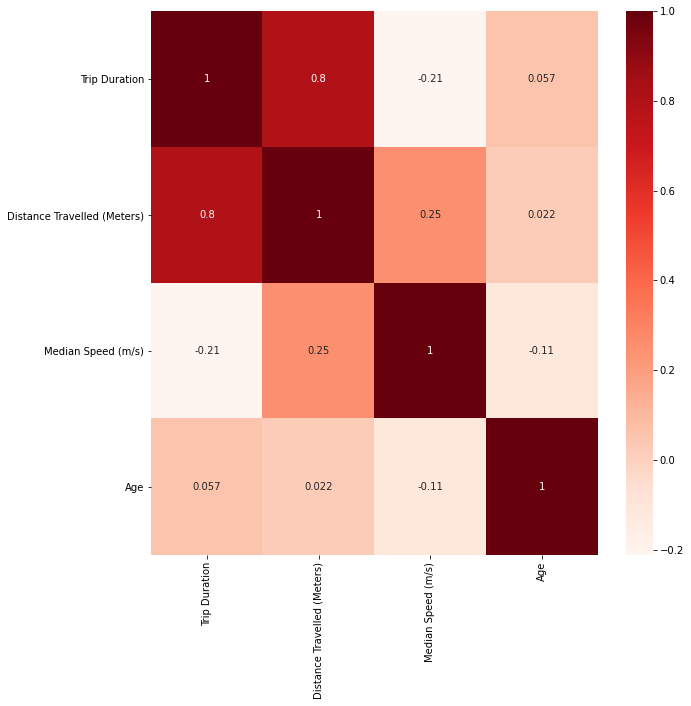

In [18]:
plt.figure(figsize=(10,10))
cor = df_model1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

###**Visualizing Target Variable - Trip Duration**

The Black line in Dist. Plot shows the mean at:  648
The Dotted line in the Dist. Plot shows the median at:  511
The Inter-quartile Range (IQR) is:  492.0
The Upper and Lower Bounds for suspected outliers in the Boxplot are 1556.0 and -412.0.


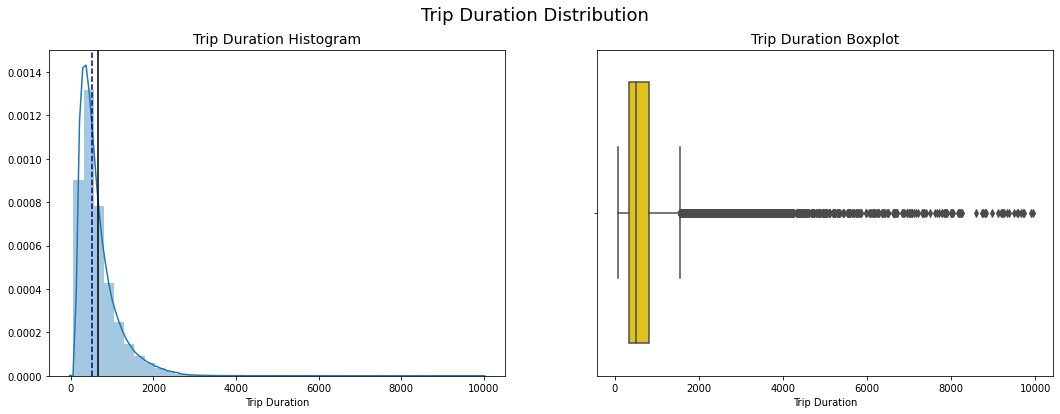

In [19]:
#Visualizing Trip Duration
f, ax = plt.subplots(1,2,figsize=(18,6))
sns.distplot(df_model1['Trip Duration'], ax=ax[0], bins=40, kde=True, 
             norm_hist=True)
ax[0].axvline(np.mean(df_model1['Trip Duration']), color='black')
ax[0].axvline(np.median(df_model1['Trip Duration']), color='darkblue', 
              linestyle='--')
ax[0].set_title('Trip Duration Histogram',fontsize = 14)
sns.boxplot(df_model1['Trip Duration'], ax=ax[1], color='gold')
ax[1].set_title('Trip Duration Boxplot', fontsize = 14)
f.suptitle('Trip Duration Distribution', fontsize = 18)

print("The Black line in Dist. Plot shows the mean at: ",
      round(df_model1['Trip Duration'].mean()))
print("The Dotted line in the Dist. Plot shows the median at: ",
      round(df_model1['Trip Duration'].median()))

#Displaying the Upper & Lower limits of the range of Salary with IQR rule.
stat = df_model1['Trip Duration'].describe()
#print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The Inter-quartile Range (IQR) is: ', IQR)
print('The Upper and Lower Bounds for suspected outliers in the Boxplot are {} and {}.'.format(upper, lower))

###**Visualizing Correlation between Features & Target Variable**

In [20]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412211 entries, 0 to 412210
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Trip Duration                412211 non-null  int64         
 1   Start Time                   412211 non-null  datetime64[ns]
 2   Stop Time                    412211 non-null  datetime64[ns]
 3   Start Station Name           412211 non-null  category      
 4   End Station Name             412211 non-null  category      
 5   Bike ID                      412211 non-null  object        
 6   User Type                    412211 non-null  category      
 7   Gender                       412211 non-null  category      
 8   Distance Travelled (Meters)  412211 non-null  float64       
 9   Median Speed (m/s)           412211 non-null  float64       
 10  Age                          412211 non-null  int64         
dtypes: category(4), datetime64

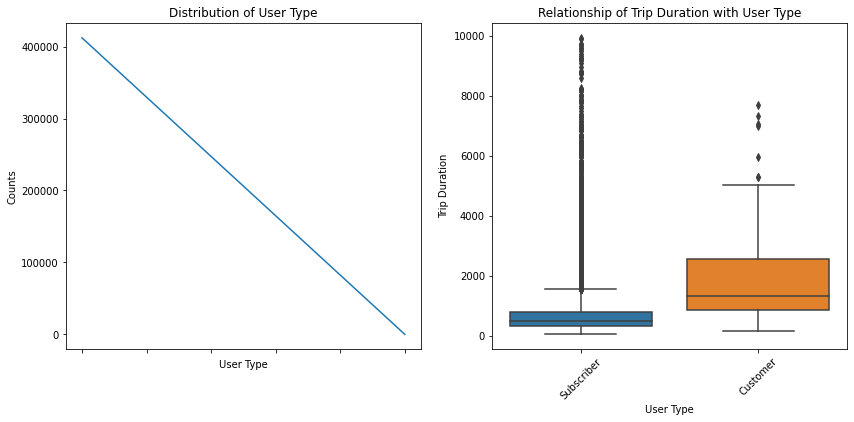

In [21]:
plot_var(df_model1, 'User Type')

##**Feature Engineering**

###**Checking for Rush Hour by checking 'Weekend' and 'Time of the Year'**

The **Start and Stop times** can now serve only one purpose in modelling - categorizing whether a trip was made during a **'Rush Hour'** or not. We are mostly looking to determine if the trip was started during a rush hour or not as that can impact the trip duration.

**1 = Weekday** and **0 = Weekend**

From common knowledge, we can apply a function that will help convert the start time to a column stating the traffic condition.

Once the times are converted into **Datetime** format, we can easily make use of some its inbuilt functions. 

From common knowledge, we will define rush hours according to the traffic usually seen in the early morning, lunch time and evening. Anytime outside that can be called not rush hour. **Please refer to the helper functions to find the conditions applied**

In [22]:
# Winter(0), Spring(1), Summer(2) and Fall(9)
 # Night (20:00 - 5:00), Morning (5:00 - 12:00), Afternoon (12:00 - 15:00),
  # Evening (15:00 - 20:00)
  
df_model1 = get_date_info(df_model1)

In [23]:
df_model1.head()

,Trip Duration,Start Time,Stop Time,Start Station Name,End Station Name,Bike ID,User Type,Gender,Distance Travelled (Meters),Median Speed (m/s),Age,d_week,Time_of_Day
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,25542.0,Subscriber,2.0,874.394902,1.285875,55,0,Night
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,21136.0,Subscriber,2.0,2160.858819,1.685537,33,0,Night
2,559,2017-01-01 00:05:00,2017-01-01 00:14:20,Broadway & W 60 St,9 Ave & W 45 St,27294.0,Subscriber,1.0,1269.844833,2.271637,47,0,Night
3,826,2017-01-01 00:05:37,2017-01-01 00:19:24,Broadway & W 37 St,E 10 St & Avenue A,23288.0,Subscriber,2.0,2753.588103,3.333642,43,0,Night
4,255,2017-01-01 00:05:47,2017-01-01 00:10:02,York St & Jay St,Carlton Ave & Flushing Ave,25041.0,Subscriber,1.0,1157.737648,4.540148,31,0,Night


In [24]:
df_model1['Time_of_Day'].value_counts()

Morning      170778
Evening      143155
Afternoon     63030
Night         35248
Name: Time_of_Day, dtype: int64

In [25]:
# 1 = Weekday, 0 = Weekend
df_model1['d_week'].value_counts()

1    359253
0     52958
Name: d_week, dtype: int64

###**Checking for Speed based on Trip Route & User Type**

Some trips are up hill, others are down hill. Some routes, such as one through times square involve heavy traffic. Tourists (Customers), will usually ride more slowly with frequent stops than a Subscriber. 

Here, we'll see how these factors can correlate with the Trip Duration.

In [26]:
# Function to Find average speed as a function of Rider User Type and Trip route
df_model1 = get_speed_distance(df_model1)

In [27]:
df_model1.head(3)

,Trip Duration,Start Time,Stop Time,Start Station Name,End Station Name,Bike ID,User Type,Gender,Distance Travelled (Meters),Median Speed (m/s),Age,d_week,Time_of_Day,Trip,route_avg_speed,route_avg_duration
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,25542.0,Subscriber,2.0,874.394902,1.285875,55,0,Night,W 82 St & Central Park West TO Central Park We...,2.696766,274.0
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,21136.0,Subscriber,2.0,2160.858819,1.685537,33,0,Night,Cooper Square & E 7 St TO Broadway & W 32 St,2.028750,1096.5
2,559,2017-01-01 00:05:00,2017-01-01 00:14:20,Broadway & W 60 St,9 Ave & W 45 St,27294.0,Subscriber,1.0,1269.844833,2.271637,47,0,Night,Broadway & W 60 St TO 9 Ave & W 45 St,2.498527,478.5


In [28]:
df_model1.shape

(412211, 16)

We see that average trip durations between rush hours & otherwise are quiet equally divided. We can't say if adding this column will be very effective for the predictive model, but we can certainly drop the start and stop times now

###**Vizualizing Correlation b/w Features & Target Variable**

In [29]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412211 entries, 0 to 412210
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Trip Duration                412211 non-null  int64         
 1   Start Time                   412211 non-null  datetime64[ns]
 2   Stop Time                    412211 non-null  datetime64[ns]
 3   Start Station Name           412211 non-null  object        
 4   End Station Name             412211 non-null  object        
 5   Bike ID                      412211 non-null  object        
 6   User Type                    412211 non-null  category      
 7   Gender                       412211 non-null  category      
 8   Distance Travelled (Meters)  412211 non-null  float64       
 9   Median Speed (m/s)           412211 non-null  float64       
 10  Age                          412211 non-null  int64         
 11  d_week                    

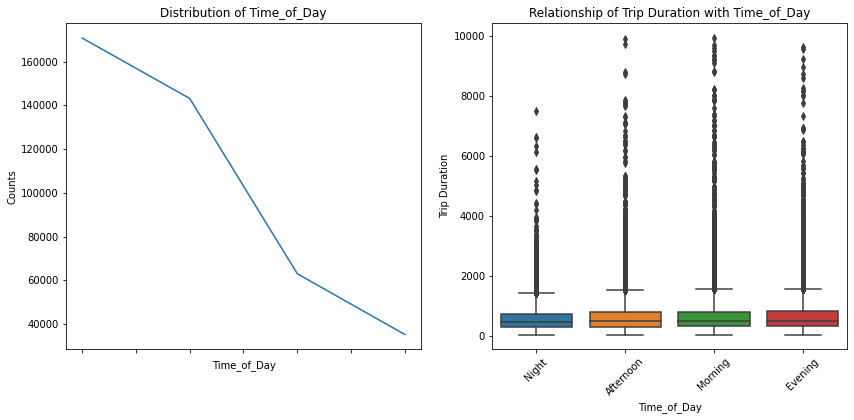

In [30]:
plot_var(df_model1, 'Time_of_Day')

##**Pre-Processing Data**

####**Log Transformation of Skewed Numerical Features**

Before performing machine learning, we will transform some features to avoid introducing some bias due to the overall distribution of the latter. As mentioned previously, we have some skewed distributions and they can make our models underperformed. To potentially solve this issue, we will apply a logarithmic transformation to reduce the effect of outliers and reduce the distribution's range.

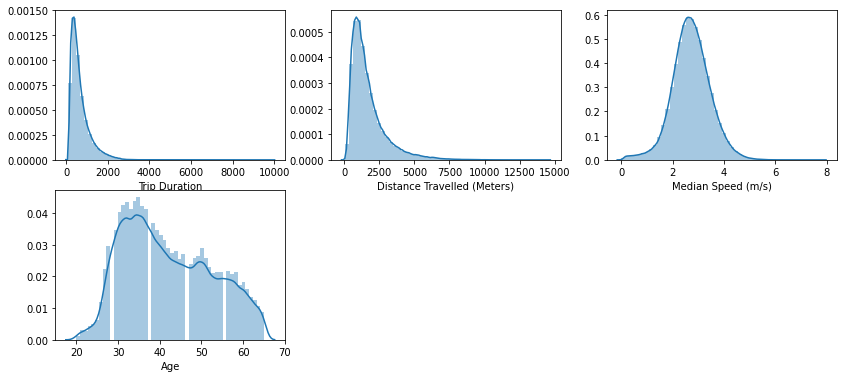

In [31]:
creating_distplot((14,16), df_model1, num_vars)

Skewness in Distance Travelled after Log Transformation: 0.032008396871422914


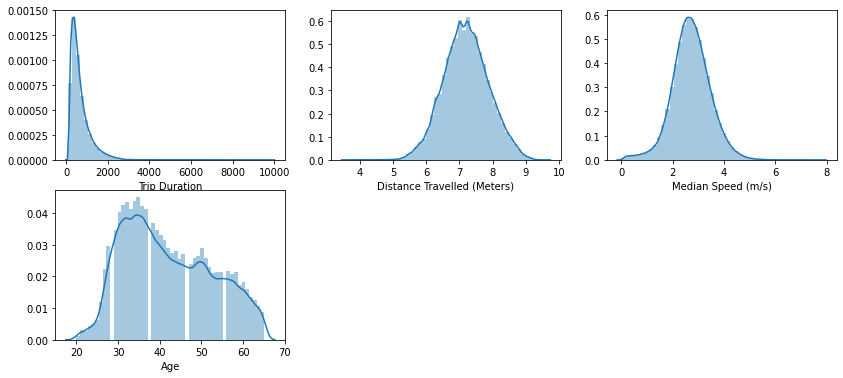

In [32]:
#Log transformation to remove skewnewss
df_model1["Distance Travelled (Meters)"] = np.log(df_model1["Distance Travelled (Meters)"])
print("Skewness in Distance Travelled after Log Transformation:",
      df_model1["Distance Travelled (Meters)"].skew())

creating_distplot((14,16), df_model1, num_vars)

The distribution looks a lot better now.

####**Scaling of Numerical Features**

We use MinMax because we saw earlier that our distribution was not uniform in all cases. However, we also know that MinMax is sensitive to outliers. We will first try MinMax.

In [33]:
numerical_vars.head()

,Trip Duration,Distance Travelled (Meters),Median Speed (m/s),Age
0,680,874.394902,1.285875,55
1,1282,2160.858819,1.685537,33
2,559,1269.844833,2.271637,47
3,826,2753.588103,3.333642,43
4,255,1157.737648,4.540148,31


In [34]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412211 entries, 0 to 412210
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Trip Duration                412211 non-null  int64         
 1   Start Time                   412211 non-null  datetime64[ns]
 2   Stop Time                    412211 non-null  datetime64[ns]
 3   Start Station Name           412211 non-null  object        
 4   End Station Name             412211 non-null  object        
 5   Bike ID                      412211 non-null  object        
 6   User Type                    412211 non-null  category      
 7   Gender                       412211 non-null  category      
 8   Distance Travelled (Meters)  412211 non-null  float64       
 9   Median Speed (m/s)           412211 non-null  float64       
 10  Age                          412211 non-null  int64         
 11  d_week                    

In [35]:
# Initializing a scaler, then apply it to the features
scaler1 = MinMaxScaler()
df_model1['Distance Travelled (Meters)'] = scaler1.fit_transform(df_model1[['Distance Travelled (Meters)']])

scaler2 = MinMaxScaler()
df_model1['Median Speed (m/s)'] = scaler2.fit_transform(df_model1[['Median Speed (m/s)']])

scaler3 = MinMaxScaler()
df_model1['route_avg_speed'] = scaler3.fit_transform(df_model1[['route_avg_speed']])

scaler4 = MinMaxScaler()
df_model1['route_avg_duration'] = scaler4.fit_transform(df_model1[['route_avg_duration']])

scaler5 = MinMaxScaler()
df_model1['Age'] = scaler5.fit_transform(df_model1[['Age']]) 

df_model1.head()

,Trip Duration,Start Time,Stop Time,Start Station Name,End Station Name,Bike ID,User Type,Gender,Distance Travelled (Meters),Median Speed (m/s),Age,d_week,Time_of_Day,Trip,route_avg_speed,route_avg_duration
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,25542.0,Subscriber,2.0,0.530456,0.163934,0.777778,0,Night,W 82 St & Central Park West TO Central Park We...,0.340285,0.021921
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,21136.0,Subscriber,2.0,0.681875,0.215146,0.288889,0,Night,Cooper Square & E 7 St TO Broadway & W 32 St,0.254108,0.106969
2,559,2017-01-01 00:05:00,2017-01-01 00:14:20,Broadway & W 60 St,9 Ave & W 45 St,27294.0,Subscriber,1.0,0.592903,0.290247,0.600000,0,Night,Broadway & W 60 St TO 9 Ave & W 45 St,0.314712,0.043067
3,826,2017-01-01 00:05:37,2017-01-01 00:19:24,Broadway & W 37 St,E 10 St & Avenue A,23288.0,Subscriber,2.0,0.722444,0.426330,0.511111,0,Night,Broadway & W 37 St TO E 10 St & Avenue A,0.373102,0.091718
4,255,2017-01-01 00:05:47,2017-01-01 00:10:02,York St & Jay St,Carlton Ave & Flushing Ave,25041.0,Subscriber,1.0,0.577434,0.580929,0.244444,0,Night,York St & Jay St TO Carlton Ave & Flushing Ave,0.398333,0.031693


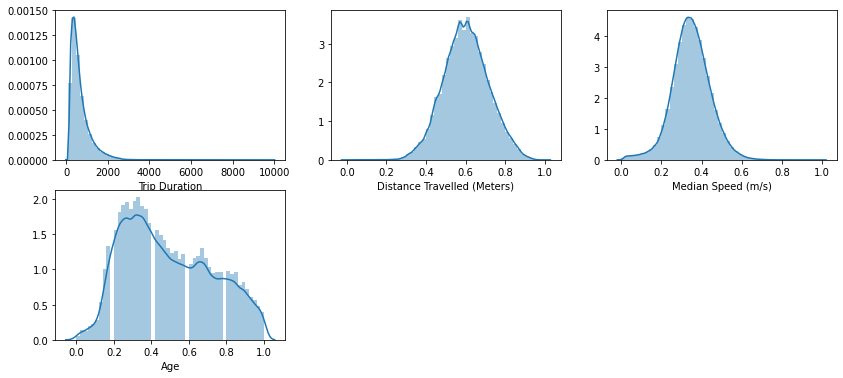

In [36]:
creating_distplot((14,16), df_model1, num_vars)

In [37]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412211 entries, 0 to 412210
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Trip Duration                412211 non-null  int64         
 1   Start Time                   412211 non-null  datetime64[ns]
 2   Stop Time                    412211 non-null  datetime64[ns]
 3   Start Station Name           412211 non-null  object        
 4   End Station Name             412211 non-null  object        
 5   Bike ID                      412211 non-null  object        
 6   User Type                    412211 non-null  category      
 7   Gender                       412211 non-null  category      
 8   Distance Travelled (Meters)  412211 non-null  float64       
 9   Median Speed (m/s)           412211 non-null  float64       
 10  Age                          412211 non-null  float64       
 11  d_week                    

####**Encoding Categorical Variables**

It is important to create dummy variables for the cateogrical columns in the dataset. For this, it is better to drop the Start & End Station Names columns. Also, Bike ID is probably not a very good predictor.

In [38]:
#We can drop 'Trip' since we only needed it to find avg speed & duration based
# on the trip route and user type.
df_model1.drop(['Start Station Name', 'End Station Name', 'Bike ID','Trip',
                'Start Time', 'Stop Time'], axis = 1, inplace = True)

**Memory Issues while Encoding**: get_dummies returns an 8-bit integer rather than a 64-bit float, which actually generates the dummies we need.

However, the 'Trip' column has a too many uniques categories. The *sparse* method can be tried below to see if that makes any difference to the large number of dummies to be generated. **However**, we don't really need the 'Trip' variable anymore. The only predictive contribution from 'Trip' was information related to the particular 'Routes'. We already have the **average speeds & durations** based on User Type and Trip Route. Therefore, it can be dropped.

In [39]:
df_model1 = pd.concat([df_model1,
                       pd.get_dummies(df_model1['User Type'],
                                      prefix = 'User Type', drop_first = True)],
                      axis = 1)
df_model1 = pd.concat([df_model1,
                       pd.get_dummies(df_model1['Gender'],
                                      prefix = 'Gender', drop_first = True)],
                      axis = 1)
df_model1 = pd.concat([df_model1,
                       pd.get_dummies(df_model1['d_week'],
                                      prefix='d_week', drop_first = True)],
                      axis = 1)
df_model1 = pd.concat([df_model1,
                       pd.get_dummies(df_model1['Time_of_Day'],
                                      prefix='Time_of_Day', drop_first = True)],
                      axis = 1)

#Once we have generated dummies, we can drop the original columns
df_model1.drop(['User Type', 'Gender', 'd_week', 'Time_of_Day'], axis = 1, 
               inplace = True)
df_model1.head()

,Trip Duration,Distance Travelled (Meters),Median Speed (m/s),Age,route_avg_speed,route_avg_duration,User Type_Customer,Gender_1.0,Gender_2.0,d_week_1,Time_of_Day_Afternoon,Time_of_Day_Morning,Time_of_Day_Evening
0,680,0.530456,0.163934,0.777778,0.340285,0.021921,0,0,1,0,0,0,0
1,1282,0.681875,0.215146,0.288889,0.254108,0.106969,0,0,1,0,0,0,0
2,559,0.592903,0.290247,0.600000,0.314712,0.043067,0,1,0,0,0,0,0
3,826,0.722444,0.426330,0.511111,0.373102,0.091718,0,0,1,0,0,0,0
4,255,0.577434,0.580929,0.244444,0.398333,0.031693,0,1,0,0,0,0,0


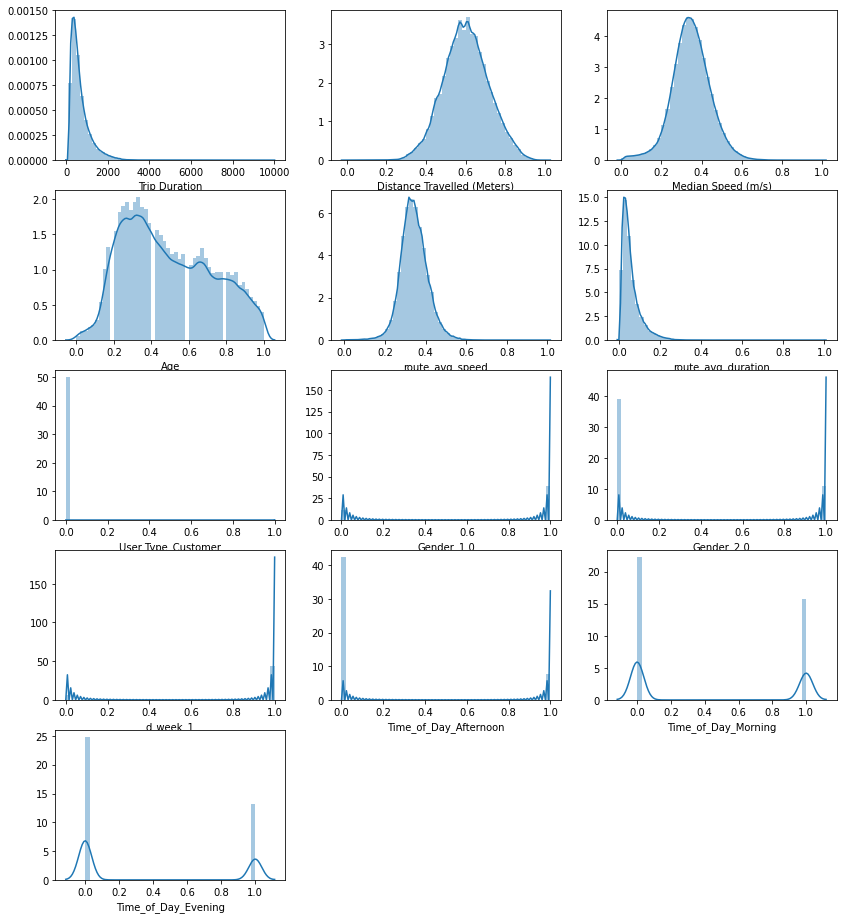

In [40]:
# Sanity Check
creating_distplot((14,16), df_model1, df_model1.columns)

In [41]:
df_model1.to_csv('ModellingData_Citibike_2017.csv')

##**Predictive Modelling**

####**Training & Testing Split**

In [42]:
X = df_model1.drop('Trip Duration', axis = 1)
y = df_model1['Trip Duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [43]:
#Sanity Check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(329768, 12)
(329768,)
(82443, 12)
(82443,)


##**Model Selection**

###**Establishing Baseline with Simple Linear Regression**

Having performed EDA and establishing that this is a regression problem, we know that we are to predict the continuous variable, Trip Duration, from the recently cleaned data

In [44]:
#Simple Linear Regression Object
lr = LinearRegression()

#Fitting model
lr.fit(X_train, y_train)

#Evaluating the model fit
lr.score(X_test, y_test)

0.8740690814388551

In [45]:
#Making Predictions so that y_hat gives an array of Target values
y_test_hat = lr.predict(X_test)
y_train_hat = lr.predict(X_train)
print("First 5 Actual Trip Durations (Test Set):", y_test[0:5])
print("First 5 predicted Trip Durations:",y_test_hat[0:5])

First 5 Actual Trip Durations (Test Set): 152423     610
208595    1258
383051     368
330591     792
230975     120
Name: Trip Duration, dtype: int64
First 5 predicted Trip Durations: [ 595.70132709 1241.31958227  280.05922333  776.01971433  113.55076506]


####**Evaluating Baseline**

In [46]:
#Evaluation
mse_lr = mean_squared_error(y_test, y_test_hat)

print("Mean absolute error (MAE): %.2f" % np.mean(np.absolute(y_test_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % mse_lr)
print('R-Square is: %.2f' % lr.score(X_test,y_test))

Mean absolute error (MAE): 72.50
Residual sum of squares (MSE): 29342.00
R-Square is: 0.87


In [47]:
#Prediction accuracy using 5-cross validation
Rcross = cross_val_score(lr, X_train, y_train, cv = 5)

print("The k-cross validation accuracy is: %0.2f (+/- %0.2f)" % ((Rcross.mean(),
                                                                  Rcross.std()*2)))

The k-cross validation accuracy is: 0.87 (+/- 0.01)


#####**Baseline Model Summary**

In [48]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
lr_OLS = sm.OLS(y_train, X_train).fit()
lr_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Trip Duration   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                 1.901e+05
Date:                Mon, 17 Aug 2020   Prob (F-statistic):               0.00
Time:                        08:37:09   Log-Likelihood:            -2.1634e+06
No. Observations:              329768   AIC:                         4.327e+06
Df Residuals:                  329755   BIC:                         4.327e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         163.8776      5.515     29.716      0.000     153.069     174.686
Distance Travelled (Meters)   143.1083      6.559     21.817      0.000     130.252     155.965
Median Speed (m/s)          -2205.6227      4.422   -498.812      0.000   -2214.289   -2196.956
Age                           -14.8619      1.275    -11.657      0.000     -17.361     -12.363
route_avg_speed              1914.5554      7.339    260.891      0.000    1900.172    1928.939
route_avg_duration           9147.9760     15.324    596.969      0.000    9117.941    9178.011
User Type_Customer            -21.6866     16.514     -1.313      0.189     -54.054      10.681
Gender_1.0                      7.6707      4.815      1.593      0.111      -1.767      17.108
Gender_2.0                    -13.0299      4.845     -2.689      0.007     -22.526      -3.534
d_week_1                       -8.9563      0.899     -9.965      0.000     -10.718      -7.195
Time_of_Day_Afternoon          -0.5419      1.278     -0.424      0.672      -3.047       1.963
Time_of_Day_Morning            -6.6530      1.125     -5.915      0.000      -8.858      -4.448
Time_of_Day_Evening            -8.3297      1.144     -7.281      0.000     -10.572      -6.087
==============================================================================
Omnibus:                   624256.657   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2559074725.307
Skew:                          14.306   Prob(JB):                         0.00
Kurtosis:                     433.612   Cond. No.                         111.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

####**Distribution Plot for SLR**

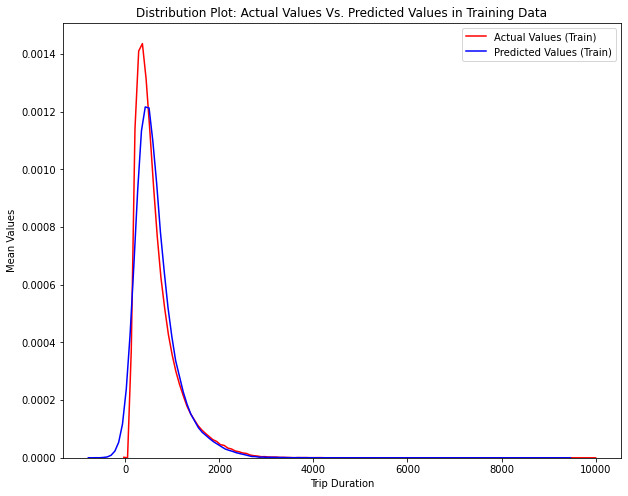

In [49]:
#Training Values Distribution plot for SLR
Title = 'Distribution Plot: Actual Values Vs. Predicted Values in Training Data'
DistributionPlot(y_train, y_train_hat, "Actual Values (Train)",
                 "Predicted Values (Train)", Title)

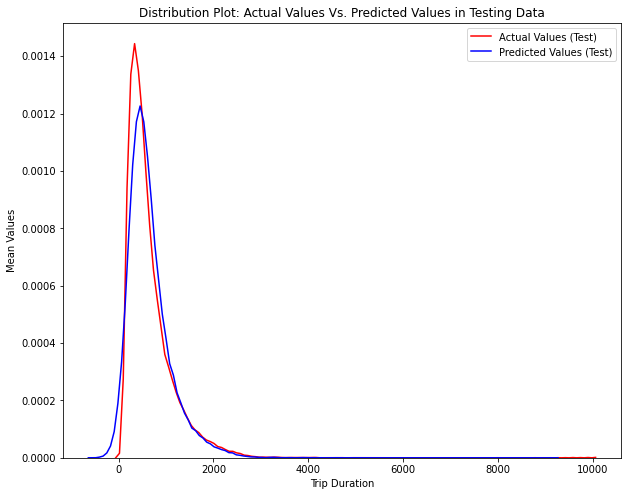

In [50]:
#Testing Values Distribution plot for SLR
Title = 'Distribution Plot: Actual Values Vs. Predicted Values in Testing Data'
DistributionPlot(y_test, y_test_hat, "Actual Values (Test)",
                 "Predicted Values (Test)", Title)

Plots are not that different with the mean of actual values higher than the mean of predicted values

###**Random Forest Regressor**

In [51]:
#Initializing Ranom Forest Object
rf = RandomForestRegressor(n_estimators = 50, random_state = 0, 
                           min_samples_leaf = 300)

#Fitting Model on training data
rf.fit(X_train, y_train)

#Making predictions
rf_pred = rf.predict(X_test)
print("First 5 predicted Trip Durations (RF):", rf_pred[0:5])

First 5 predicted Trip Durations (RF): [ 615.75953566 1303.01917262  367.63233813  758.23937343  121.71556622]


In [52]:
y_test[0:5]

152423     610
208595    1258
383051     368
330591     792
230975     120
Name: Trip Duration, dtype: int64

In [53]:
#Evaluating Model Fit
rf.score(X_test, y_test)

0.9239466935682036

####**Evaluating Random Forest Regression**

In [54]:
#Calculating Absolute Error
rf_errors = abs(rf_pred - y_test)

#Mean Absolute Error
print('Mean Absolute Error (MAE):', round(np.mean(np.absolute(rf_pred - y_test)),2), 'degrees')

#Mean Absolute Percentage Error (MAPE)
rf_mape = 100*(rf_errors/y_test)

#Model Accuracy
rf_accuracy = 100 - np.mean(rf_mape)
print('Random Forest Accuracy:', round(rf_accuracy, 2), '%')

Mean Absolute Error (MAE): 27.66 degrees
Random Forest Accuracy: 96.55 %


In [55]:
#Evaluating with MSE
round(mean_squared_error(y_test, rf_pred),2)

17720.48

In [56]:
#Prediction accuracy using 5-cross validation
Rcross = cross_val_score(rf, X_train, y_train, cv = 5)

print("The k-cross validation accuracy is: %0.2f (+/- %0.2f)" % ((Rcross.mean(),
                                                                  Rcross.std()*2)))

The k-cross validation accuracy is: 0.93 (+/- 0.01)


####**RF Feature Importance Model**

In [57]:
X_train.shape

(329768, 13)

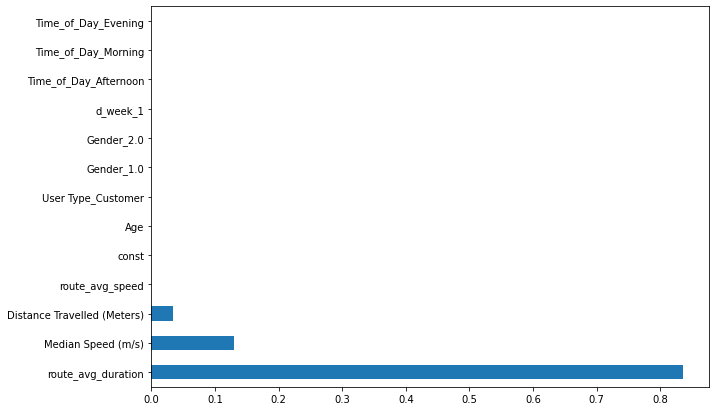

In [58]:
# plot the 18 features in order of importance 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(rf.feature_importances_, index = X_train.columns)
feat_importances.nlargest(18).plot(kind='barh');

Lets train the same Random Forest model based on only the above 3 features and see if we can further reduce that MSE for test set

In [59]:
X_train_if = X_train[['Distance Travelled (Meters)',
                      'route_avg_duration', 'Median Speed (m/s)']]

X_test_if = X_test[['Distance Travelled (Meters)',
                      'route_avg_duration', 'Median Speed (m/s)']]

In [60]:
#New object for the RF model
rf_if = RandomForestRegressor(n_estimators = 50, random_state = 0,
                              min_samples_leaf = 300)

#Fitting model with training data
rf_if.fit(X_train_if, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=300,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [61]:
y_test[0:5]

152423     610
208595    1258
383051     368
330591     792
230975     120
Name: Trip Duration, dtype: int64

In [62]:
#predicting
rf_pred_if = rf_if.predict(X_train_if)
rf_pred_if = rf_if.predict(X_test_if)

print("First 5 predicted Trip Durations (RF):", rf_pred_if[0:5])

First 5 predicted Trip Durations (RF): [ 615.75953566 1303.01917262  367.63233813  758.23937343  121.71556622]


####**Evaluating RF Importance Model**

In [63]:
#Evaluating Model Fit
rf_if.score(X_test_if, y_test)

0.9238921562226626

In [64]:
#Evaluating new model
#Calculating Absolute Error
rf_errors_if = abs(rf_pred_if - y_test)

#Mean Absolute Error
print('Mean Absolute Error (MAE):', 
      round(np.mean(np.absolute(rf_pred_if - y_test)),2), 'degrees')

#Mean Absolute Percentage Error (MAPE)
rf_mape_if = 100*(rf_errors_if/y_test)

#Model Accuracy
rf_accuracy_if = 100 - np.mean(rf_mape_if)
print('Random Forest Accuracy:', round(rf_accuracy_if, 2), '%')

Mean Absolute Error (MAE): 27.7 degrees
Random Forest Accuracy: 96.54 %


In [65]:
#Prediction accuracy using 5-cross validation
Rcross = cross_val_score(rf_if, X_train_if, y_train, cv = 5)

print("The k-cross validation accuracy is: %0.2f (+/- %0.2f)" % ((Rcross.mean(),
                                                                  Rcross.std()*2)))

The k-cross validation accuracy is: 0.93 (+/- 0.01)


###**Polynomial Regression**

In [66]:
#Polynomial Reg Object
poly = PolynomialFeatures(degree=2)
polyFeatures = poly.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(polyFeatures, y,
                                                    test_size = 0.2,
                                                    random_state = 42)

#Fitting Regression Model Object
reg = lr.fit(X_train, y_train)

In [67]:
y_train[0:5]

208598    1318
134628     585
22351      432
340361     291
304424     131
Name: Trip Duration, dtype: int64

In [68]:
#Prediction with Polynomial Regression
y_hat_ptrain = lr.predict(X_train)
y_hat_ptrain[0:5]

array([1302.2636255 ,  566.87140591,  444.15926936,  249.70040596,
        105.76761263])

####**Evaluating Polynomial Regression**

In [69]:
#Accuracy Score
lr.score(X_test, y_test)

0.9328668082974563

In [70]:
#Evaluation with MAE
mae_poly_train = metrics.mean_absolute_error(y_hat_ptrain, y_train)
mae_poly_train

45.58411291056747

In [71]:
#Evaluation with MSE
y_hat_ptest = lr.predict(X_test)
round(mean_squared_error(y_test, y_hat_ptest),2)

15642.08

####**Distribution Plots for Polynomial Regression**

First 5 Predictions on Training Values: [1302.2636255   566.87140591  444.15926936  249.70040596  105.76761263]
First 5 Predictions on Actual Values: [1318  585  432  291  131]


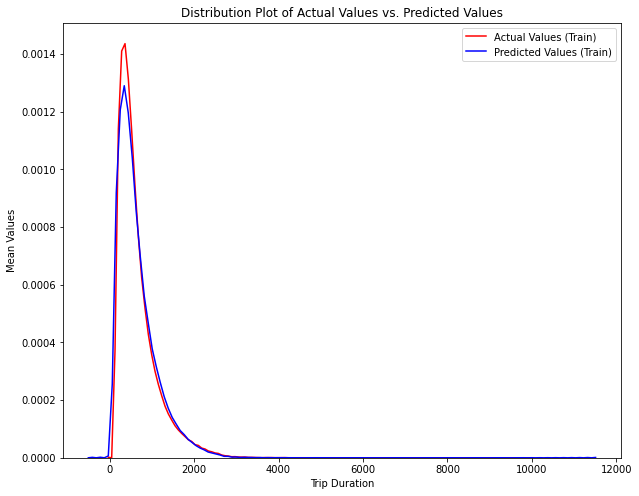

In [72]:
print("First 5 Predictions on Training Values:", y_hat_ptrain[0:5])
print("First 5 Predictions on Actual Values:", y_train[0:5].values)

#Comparing actual and predicted values with distribution plot
Title = 'Distribution Plot of Actual Values vs. Predicted Values'
DistributionPlot(y_train, y_hat_ptrain, "Actual Values (Train)", 
                 "Predicted Values (Train)", Title)

First 5 Predictions on Testing Values: [ 598.73008531 1267.64140166  346.58362072  904.18267127   71.53351965]
First 5 Predictions on Actual Values: [ 610 1258  368  792  120]


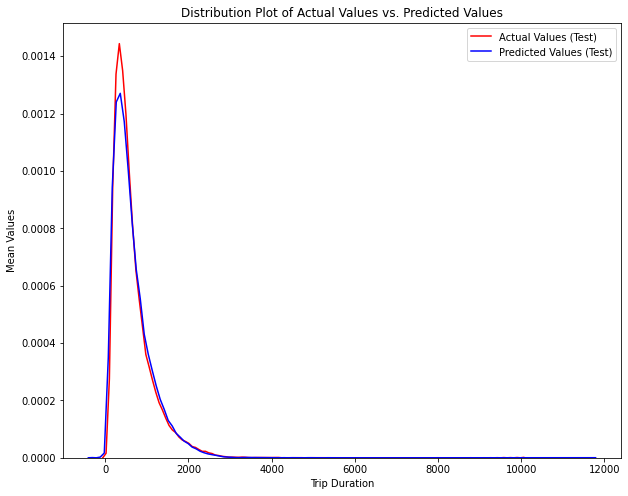

In [73]:
#Making Predictions on the test set
print("First 5 Predictions on Testing Values:", y_hat_ptest[0:5])
print("First 5 Predictions on Actual Values:", y_test[0:5].values)

#Comparing actual and predicted values with distribution plot
Title = 'Distribution Plot of Actual Values vs. Predicted Values'
DistributionPlot(y_test, y_hat_ptest, "Actual Values (Test)",
                 "Predicted Values (Test)", Title)

####**Evaluating Polynomial Regression**

In [74]:
#MSE
print("Training Data MSE:", round(mean_squared_error(y_train, y_hat_ptrain),2))
print("Testing Data MSE:", round(mean_squared_error(y_test, y_hat_ptest),2))

#R2
print("Training R-2:", round(lr.score(X_train, y_train),2))
print("Testing R-2:", round(lr.score(X_test, y_test),2))

Training Data MSE: 14541.32
Testing Data MSE: 15642.08
Training R-2: 0.94
Testing R-2: 0.93


#####**Polynomial Regression Summary**

In [75]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
poly_OLS = sm.OLS(y_train, X_train).fit()
poly_OLS.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Trip Duration   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 6.304e+04
Date:                Mon, 17 Aug 2020   Prob (F-statistic):               0.00
Time:                        08:45:11   Log-Likelihood:            -2.0483e+06
No. Observations:              329768   AIC:                         4.097e+06
Df Residuals:                  329689   BIC:                         4.098e+06
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        926.6636     32.281     28.706      0.000     863.394     989.933
x1         -1972.3537     86.383    -22.833      0.000   -2141.663   -1803.045
x2         -4496.2643     55.723    -80.689      0.000   -4605.480   -4387.048
x3            -9.6333     18.477     -0.521      0.602     -45.847      26.581
x4          1707.1950     95.735     17.832      0.000    1519.556    1894.834
x5          1097.3946    206.210      5.322      0.000     693.228    1501.561
x6           172.5764     62.497      2.761      0.006      50.083     295.069
x7            60.2483     15.242      3.953      0.000      30.374      90.123
x8            28.1001     15.351      1.830      0.067      -1.988      58.188
x9            -1.6612      5.722     -0.290      0.772     -12.876       9.554
x10           27.8153      8.174      3.403      0.001      11.794      43.837
x11           19.9537      7.334      2.721      0.007       5.578      34.329
x12           12.6379      7.473      1.691      0.091      -2.008      27.284
x13         4194.4529     48.092     87.217      0.000    4100.193    4288.712
x14         -460.8555     66.401     -6.940      0.000    -591.000    -330.711
x15          -62.7262     19.565     -3.206      0.001    -101.074     -24.378
x16        -1039.5248    107.450     -9.674      0.000   -1250.124    -828.925
x17         4852.6368    157.369     30.836      0.000    4544.198    5161.076
x18         -777.3937    170.685     -4.555      0.000   -1111.931    -442.857
x19         -197.7523     78.136     -2.531      0.011    -350.897     -44.608
x20         -166.9393     78.558     -2.125      0.034    -320.911     -12.968
x21            2.3011     13.473      0.171      0.864     -24.105      28.707
x22          -65.7843     19.583     -3.359      0.001    -104.167     -27.402
x23         -134.2319     17.669     -7.597      0.000    -168.863     -99.601
x24         -101.2956     17.898     -5.660      0.000    -136.375     -66.216
x25         1.037e+04     23.863    434.555      0.000    1.03e+04    1.04e+04
x26          237.7682     13.357     17.800      0.000     211.588     263.948
x27        -9295.3714     78.288   -118.733      0.000   -9448.814   -9141.929
x28        -2.813e+04    195.242   -144.100      0.000   -2.85e+04   -2.78e+04
x29         -553.3636   1392.899     -0.397      0.691   -3283.405    2176.678
x30         -302.0322     49.417     -6.112      0.000    -398.888    -205.176
x31          -25.2065     49.800     -0.506      0.613    -122.814      72.401
x32           95.3652      8.650     11.025      0.000      78.412     112.318
x33          -52.4420     12.456     -4.210      0.000     -76.855     -28.029
x34           -3.0829     11.223     -0.275      0.784     -25.080      18.914
x35           99.9880     11.302      8.847      0.000      77.836     122.140
x3

###**Ridge Regressor**

In [76]:
#Ridge Regressor object
rg = Ridge(alpha = 0.01)
rg.fit(X_train, y_train)
rg.score(X_test, y_test)

0.9328408739485361

In [77]:
#Predictions
y_hat_train_rg = rg.predict(X_train)
y_hat_test_rg = rg.predict(X_test)
y_hat_train_rg[0:5]

array([1302.11031799,  566.5045766 ,  444.8199334 ,  249.67257436,
        107.62169659])

####**Evaluating Ridge Regressor**

In [78]:
#Evaluation with MSE
print("Training Data MSE: ", mean_squared_error(y_train, y_hat_train_rg))
print("Test Data MSE: ", mean_squared_error(y_test, y_hat_test_rg))

#Evaluation with R^2, which is a metric for model prediction accuracy
print('Training Data R-square: ', rg.score(X_train, y_train))
print('Test Data R-square: ', rg.score(X_test, y_test))

Training Data MSE:  14543.503355307059
Test Data MSE:  15648.124906916795
Training Data R-square:  0.9371527956225647
Test Data R-square:  0.9328408739485361


First 5 Salary Predictions on test data:  [ 599.12468629 1268.89778792  345.28886613  907.21666528   71.40090851]
First 5 Actual Test Values:  [ 610 1258  368  792  120]


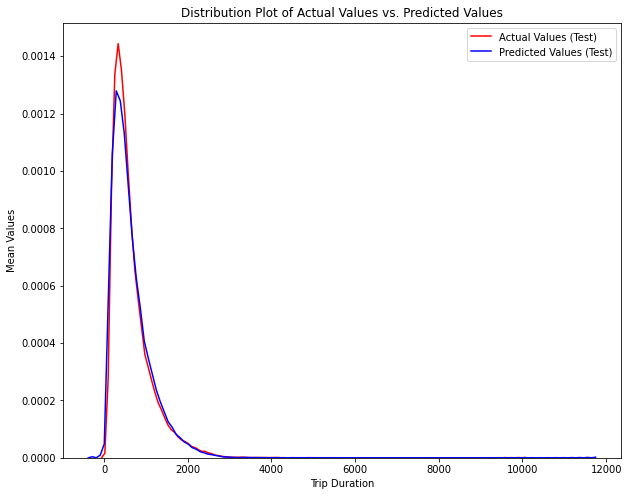

In [79]:
#Predictng Test Salaries after applying Ridge Regression)
print("First 5 Salary Predictions on test data: ", y_hat_test_rg[0:5])
print("First 5 Actual Test Values: ", y_test[0:5].values)

#Comparing actual and predicted values with distribution plot
Title = 'Distribution Plot of Actual Values vs. Predicted Values'
DistributionPlot(y_test, y_hat_test_rg, "Actual Values (Test)",
                 "Predicted Values (Test)", Title)

First 5 Salary Predictions on training data:  [1302.11031799  566.5045766   444.8199334   249.67257436  107.62169659]
First 5 Actual Training Values:  [1318  585  432  291  131]


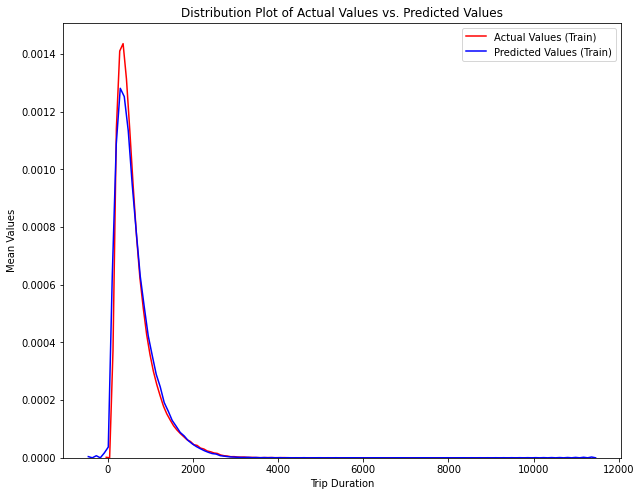

In [80]:
#Predictng Training Salaries after applying Ridge Regression
print("First 5 Salary Predictions on training data: ", y_hat_train_rg[0:5])
print("First 5 Actual Training Values: ", y_train[0:5].values)

#Comparing actual and predicted values with distribution plot
Title = 'Distribution Plot of Actual Values vs. Predicted Values'
DistributionPlot(y_train, y_hat_train_rg, "Actual Values (Train)",
                 "Predicted Values (Train)", Title)

###**Gradient Boosting Regression**

In [81]:
#Creating Gradient Boosting Regressor object
gb = GradientBoostingRegressor(n_estimators = 60, max_depth = 5,
                              loss = 'ls', verbose = 5)

In [82]:
#Fitting object to data
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1      192124.3928            7.30m
         2      159993.4100            7.05m
         3      133817.6910            6.87m
         4      112304.6751            6.77m
         5       94392.6569            6.67m
         6       79723.9647            6.55m
         7       67433.0240            6.43m
         8       57484.8285            6.33m
         9       49158.2003            6.21m
        10       42437.7136            6.09m
        11       36320.6462            5.97m
        12       31262.7582            5.85m
        13       27053.4186            5.72m
        14       23507.7939            5.60m
        15       20394.3031            5.48m
        16       17775.5529            5.36m
        17       15594.5152            5.24m
        18       13715.8809            5.12m
        19       12197.6603            4.99m
        20       10808.9741            4.87m
        21        9634.3829            4.75m
        2

0.9920685926941216

In [83]:
#Making Predictions and calculating MSE
gb_pred_test = gb.predict(X_test)
round(mean_squared_error(gb_pred_test, y_test),2)

1848.02

####**Evaluating Gradient Boosting Model**

In [85]:
#Evaluation with MSE
gb_pred_train = gb.predict(X_train)
print("Training Data MSE: ", mean_squared_error(y_train, gb_pred_train))
print("Test Data MSE: ", mean_squared_error(y_test, gb_pred_test))

#Evaluation with R^2, which is a metric for model prediction accuracy
print('Training Data R-square: ', gb.score(X_train, y_train))
print('Test Data R-square: ', gb.score(X_test, y_test))

Training Data MSE:  994.8670141610202
Test Data MSE:  1848.0236344188063
Training Data R-square:  0.9957008563177778
Test Data R-square:  0.9920685926941216


####**Distribution Plots for Gradient Boosting**

First 5 Predictions on Training Values: [1304.5901872   585.18198791  443.38416803  283.86058191  136.4693079 ]
First 5 Predictions on Actual Values: [1318  585  432  291  131]


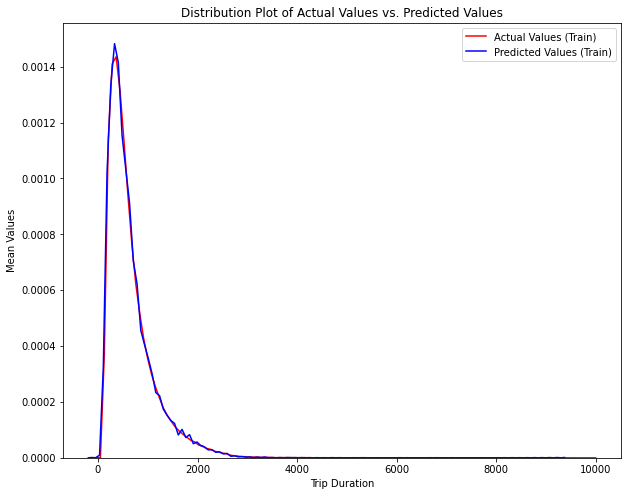

In [86]:
#Making Predictions on training set
gb_pred_train = gb.predict(X_train)
print("First 5 Predictions on Training Values:", gb_pred_train[0:5])
print("First 5 Predictions on Actual Values:", y_train[0:5].values)

#Comparing actual and predicted values with distribution plot
Title = 'Distribution Plot of Actual Values vs. Predicted Values'
DistributionPlot(y_train, gb_pred_train, "Actual Values (Train)", 
                 "Predicted Values (Train)", Title)

First 5 Predictions on Testing Values: [ 605.17387798 1279.19229737  355.9034139   755.15604011  130.08639875]
First 5 Predictions on Actual Values: [ 610 1258  368  792  120]


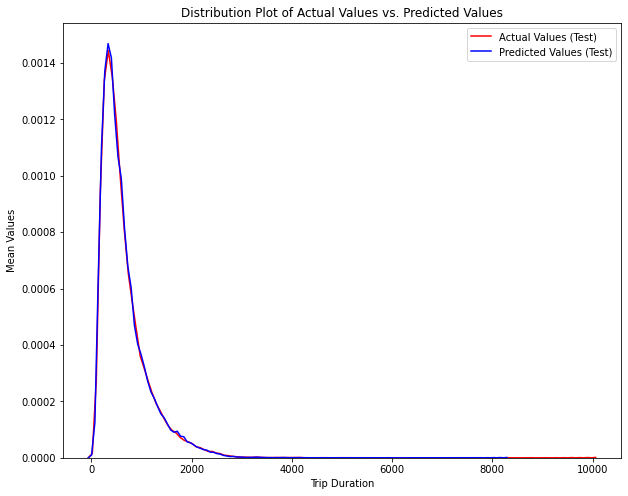

In [87]:
#Making Predictions on the test set
print("First 5 Predictions on Testing Values:", gb_pred_test[0:5])
print("First 5 Predictions on Actual Values:", y_test[0:5].values)

#Comparing actual and predicted values with distribution plot
Title = 'Distribution Plot of Actual Values vs. Predicted Values'
DistributionPlot(y_test, gb_pred_test, "Actual Values (Test)",
                 "Predicted Values (Test)", Title)

###**XGBoost Model**

In [92]:
# Converting Data set into an optimized Data Structure Dmatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 42)

#Instatiating object
xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree = 0.3,
                          learning_rate=0.1, max_depth=5, alpha = 10,
                          n_estimators=10)

#Prediction
xg_reg.fit(X_train, y_train)
y_pred_xgb_train = xg_reg.predict(X_train)
y_pred_xgb_test = xg_reg.predict(X_test)

#Accuracy
xg_reg.score(X_train, y_train)

[09:08:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.4607326537000456

####**Evaluating XGBoost**

In [93]:
#Evaluating
xgb_mse = mean_squared_error(y_test, y_pred_xgb_test)
xgb_mse

125950.32399174593

In [94]:
#k-fold Cross Validation using XGBoost
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse",
                    as_pandas=True, seed=123)

[09:12:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [95]:
#Training & Testing RMSE metrics for each boosting round
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,752.592041,0.663960,752.663228,1.434142
1,683.962931,2.598283,684.274923,4.041057
2,628.204000,9.241223,628.316122,7.329073
3,577.970703,4.682383,578.107585,5.522247
4,539.470337,8.883183,539.634114,10.658281


In [96]:
print((cv_results["test-rmse-mean"]).tail())

45    133.353851
46    130.783633
47    129.949842
48    129.572924
49    128.485865
Name: test-rmse-mean, dtype: float64


####**Distribution Plots for XGBoost**

First 5 Predictions on Training Values: [781.51776 386.45648 268.22665 239.00845 197.53412]
First 5 Predictions on Actual Values: [1318  585  432  291  131]


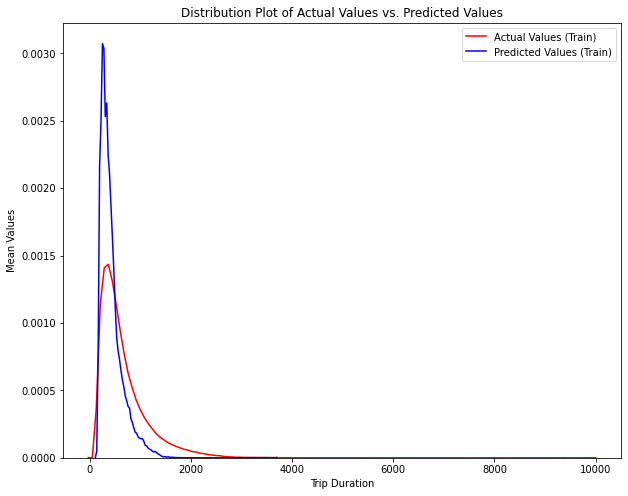

In [99]:
#Visualizing model results
#Making Predictions on training set
print("First 5 Predictions on Training Values:", y_pred_xgb_train[0:5])
print("First 5 Predictions on Actual Values:", y_train[0:5].values)

#Comparing actual and predicted values with distribution plot
Title = 'Distribution Plot of Actual Values vs. Predicted Values'
DistributionPlot(y_train, y_pred_xgb_train, "Actual Values (Train)", 
                 "Predicted Values (Train)", Title)

First 5 Predictions on Testing Values: [427.26093 828.32385 309.03745 439.64963 170.25845]
First 5 Predictions on Actual Values: [ 610 1258  368  792  120]


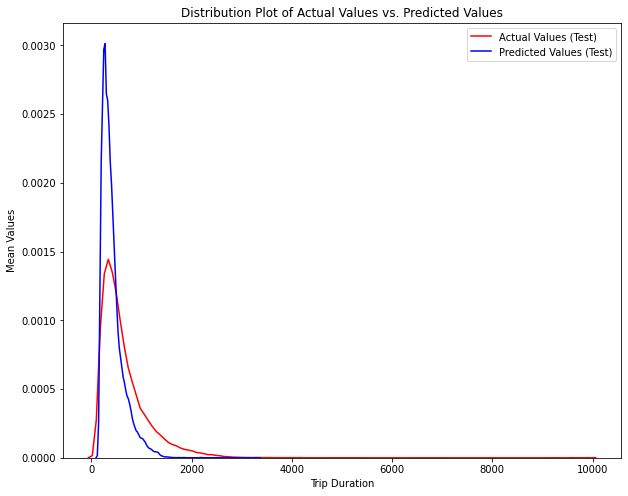

In [100]:
#Making Predictions on the test set
print("First 5 Predictions on Testing Values:", y_pred_xgb_test[0:5])
print("First 5 Predictions on Actual Values:", y_test[0:5].values)

#Comparing actual and predicted values with distribution plot
Title = 'Distribution Plot of Actual Values vs. Predicted Values'
DistributionPlot(y_test, y_pred_xgb_test, "Actual Values (Test)",
                 "Predicted Values (Test)", Title)

####**Feature Importance as per XGBoost**

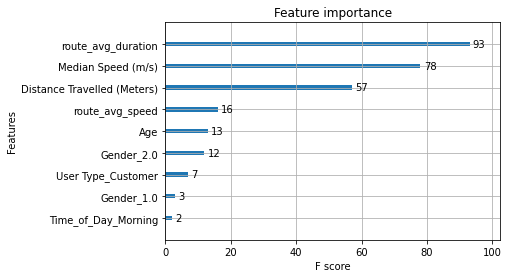

In [98]:
#Feature Importance as per XGBoost
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

##**Selecting Best Model - Gradient Boosting**

In [101]:
print("Linear Regression MSE:", round(mean_squared_error(y_test, y_test_hat),2))
print("Polynomial Regression MSE:", round(mean_squared_error(y_test, y_hat_ptest),2))
print("Random Forest MSE:", round(mean_squared_error(y_test, rf_pred),2))
print("Random Forest - IF MSE:", round(mean_squared_error(y_test, rf_pred_if),2))
print("Ridge Regressor MSE:", round(mean_squared_error(y_test, y_hat_test_rg),2))
print("XGBoost Regressor MSE:", round(mean_squared_error(y_test, y_pred_xgb_test),2))
print("Gradient Boosting Regressor MSE:", round(mean_squared_error(y_test, gb_pred_test),2))

Linear Regression MSE: 29342.0
Polynomial Regression MSE: 15642.08
Random Forest MSE: 17720.48
Random Forest - IF MSE: 17733.18
Ridge Regressor MSE: 15648.12
XGBoost Regressor MSE: 125950.32
Gradient Boosting Regressor MSE: 1848.02
